In [1]:
!which python 
!whoami 
!hostname
!pwd

/home/farshed.abdukhakimov/miniconda3/envs/main/bin/python
farshed.abdukhakimov
srv-01
/home/farshed.abdukhakimov/projects/SANIA


In [2]:
%load_ext autoreload
%autoreload 2

import os
import datetime
import time
from collections import defaultdict
import pickle

import numpy as np
import numba

import matplotlib.pyplot as plt

from experiments import utils
from experiments.loss_functions import LogisticRegressionLoss, BaseOracle
from experiments.methods import *

import scipy
# import optuna
import neptune 

import svmlight_loader

from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

np.random.seed(0)
n = 2000
d = 200
dataset_name = "synthetic-interpolation"

data, target = make_classification(n_samples=n, n_features=d, n_redundant=0, n_clusters_per_class=1, class_sep=0.8, random_state=0)
train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=0.2, random_state=0)

train_target = utils.map_classes_to(train_target, [-1.0, 1.0])
test_target = utils.map_classes_to(test_target, [-1.0, 1.0])

train_dataset = train_data, train_target
test_dataset = test_data, test_target

In [4]:
def plotter(histories, labels, colors=None, linestyles=None, 
            linewidths=None, markers=None, prefix="val", suptitle=None, 
            threshold=1e-10, max_iters=None, tight_layout=True, filename=None):
    
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16)
        
    if colors is None:
        colors = list(plt.cm.colors.XKCD_COLORS.keys())
        np.random.shuffle(colors)
        colors = list(plt.cm.colors.BASE_COLORS) + colors
        
    if linestyles is None:
        linestyles = ["-" for x in histories]
    
    if linewidths is None:
        linewidths = [1.5 for x in histories]
        
    if markers is None:
        markers = [" " for x in histories]
        
    if max_iters is None:
        max_iters = np.max([len(x[f"test/loss"]) for x in histories])
    
    for history, label, c, ls, lw, m in zip(histories, labels, colors, linestyles, linewidths, markers):
        f_suboptim_train = history[f"train/loss"]
        
        if len(f_suboptim_train) >= 10:
            markevery = [x + np.random.randint(0, 3) for x in range(0, len(f_suboptim_train), len(f_suboptim_train) // 10)]
        else:
            markevery = [x for x in range(0, len(f_suboptim_train))]
            
        ax[0].semilogy(f_suboptim_train, linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m)
        
        f_suboptim_test = history[f"test/loss"]
        ax[1].semilogy(f_suboptim_test, linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m)
        
        ax[2].plot(history["test/acc"], linestyle=ls, linewidth=lw, color=c, label=label, markevery=markevery, marker=m)
        
        ax[3].plot(history["lr"], linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m)

    ax[0].set_ylabel("Train Loss")
    ax[1].set_ylabel("Test Loss")
    ax[2].set_ylabel("Accuracy")
    ax[3].set_ylabel("Stepsize")

    # ax[1].set_ylim(bottom=0.75)
    
    ax[0].set_xlabel("Epochs")
    ax[1].set_xlabel("Epochs")
    ax[2].set_xlabel("Epochs")
    ax[3].set_xlabel("Iterations")


    fig.legend()
    ax[0].grid()
    ax[1].grid()
    ax[2].grid()
    ax[3].grid()

    if tight_layout:
        fig.tight_layout()
        
    if filename is not None:
        fig.savefig(filename)
    else:
        fig.show() 

In [218]:
def plotter(histories, labels, colors=None, linestyles=None, 
            linewidths=None, markers=None, markersizes=None, prefix="val", suptitle=None, 
            ylim=None, max_iters=None, tight_layout=True, filename=None):
    
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16)
        
    if colors is None:
        colors = list(plt.cm.colors.XKCD_COLORS.keys())
        np.random.shuffle(colors)
        colors = list(plt.cm.colors.BASE_COLORS) + colors
        
    if linestyles is None:
        linestyles = ["-" for _ in histories]
    
    if linewidths is None:
        linewidths = [1.5 for _ in histories]
        
    if markers is None:
        markers = [" " for _ in histories]
        
    if markersizes is None:
        markersizes = [6.0 for _ in histories]
        
    for history, label, c, ls, lw, m, ms in zip(histories, labels, colors, linestyles, linewidths, markers, markersizes):
        
        train_loss = [x["train/loss"] for x in history]
        
        mean_line = np.mean(train_loss, axis=0)
        max_line = np.max(train_loss, axis=0)
        min_line = np.min(train_loss, axis=0)
        x = np.linspace(0, mean_line.shape[0] - 1, mean_line.shape[0])
        
        if len(mean_line) >= 10:
            markevery = [0,] + [x + np.random.randint(0, 5) for x in range(0, len(mean_line) - 5, len(mean_line) // 10)]
        else:
            markevery = [0,] + [x for x in range(0, len(mean_line))]
            
        ax[0].fill_between(x, max_line, min_line, color=c, alpha=0.15) 
        ax[0].semilogy(x, mean_line, color=c, linestyle=ls, linewidth=lw, marker=m, markersize=ms, markevery=markevery, label=label)
        
        
        test_loss = [x["test/loss"] for x in history]
        
        mean_line = np.mean(test_loss, axis=0)
        max_line = np.max(test_loss, axis=0)
        min_line = np.min(test_loss, axis=0)
        x = np.linspace(0, mean_line.shape[0] - 1, mean_line.shape[0])
            
        ax[1].fill_between(x, max_line, min_line, color=c, alpha=0.15) 
        ax[1].semilogy(x, mean_line, color=c, linestyle=ls, linewidth=lw, marker=m, markersize=ms, markevery=markevery)
        
        
        train_loss = [x["test/acc"] for x in history]
        
        mean_line = np.mean(train_loss, axis=0)
        max_line = np.max(train_loss, axis=0)
        min_line = np.min(train_loss, axis=0)
        x = np.linspace(0, mean_line.shape[0] - 1, mean_line.shape[0])
            
        ax[2].fill_between(x, max_line, min_line, color=c, alpha=0.15) 
        ax[2].plot(x, mean_line, color=c, linestyle=ls, linewidth=lw, marker=m, markersize=ms, markevery=markevery)
        
        
        lrs = [x["lr"] for x in history]
        
        mean_line = np.mean(lrs, axis=0)
        max_line = np.max(lrs, axis=0)
        min_line = np.min(lrs, axis=0)
        x = np.linspace(0, mean_line.shape[0] - 1, mean_line.shape[0])
        
        if len(mean_line) >= 10:
            markevery = [0,] + [x + np.random.randint(0, 10) for x in range(0, len(mean_line) - 10, len(mean_line) // 10)]
        else:
            markevery = [0,] + [x for x in range(0, len(mean_line))]
            
        ax[3].fill_between(x, max_line, min_line, color=c, alpha=0.15) 
        ax[3].plot(x, mean_line, color=c, linestyle=ls, linewidth=lw, marker=m, markersize=ms, markevery=markevery)
        

    ax[0].set_ylabel("Train Loss")
    ax[1].set_ylabel("Test Loss")
    ax[2].set_ylabel("Accuracy")
    ax[3].set_ylabel("Stepsize")

    if ylim:
        ax[2].set_ylim(bottom=ylim, top=1.01)
    
    ax[0].set_xlabel("Epochs")
    ax[1].set_xlabel("Epochs")
    ax[2].set_xlabel("Epochs")
    ax[3].set_xlabel("Steps")


    fig.legend()
    ax[0].grid()
    ax[1].grid()
    ax[2].grid()
    ax[3].grid()

    if tight_layout:
        fig.tight_layout()
        
    if filename is not None:
        directory = os.getenv("PLOTS_DIR") + "/" + datetime.datetime.today().strftime("%d-%m-%Y")
        if not os.path.exists(directory):
            os.makedirs(directory)
        fig.savefig(directory + "/" + filename)
    else:
        fig.show() 

In [191]:
def one_cycle_lr(eta_max, eta_min, t_up, t_total, num_steps):
    """
    Implements OneCycleLR learning rate schedule.
    
    Parameters:
    - eta_max: Maximum learning rate.
    - eta_min: Minimum learning rate.
    - t_up: Number of steps in the warm-up phase.
    - t_total: Total number of steps.
    - num_steps: Number of steps to compute learning rates for.
    
    Returns:
    - lrs: Array of learning rates for each step.
    """
    lrs = []
    for t in range(num_steps):
        if t < t_up:  # Warm-up phase
            lr = eta_min + (t / t_up) * (eta_max - eta_min)
        else:  # Decay phase
            lr = eta_min + 0.5 * (eta_max - eta_min) * (1 + np.cos(np.pi * (t - t_up) / (t_total - t_up)))
        lrs.append(lr)
    return np.array(lrs)
        
        
def cosine_annealing_lr(eta_max, eta_min, T_max, num_steps):
    """
    Implements cosine annealing learning rate schedule.
    
    Parameters:
    - eta_max: Maximum learning rate.
    - eta_min: Minimum learning rate.
    - T_max: Total number of steps for one cycle.
    - num_steps: Number of steps to compute learning rates for.
    
    Returns:
    - lrs: Array of learning rates for each step.
    """
    lrs = []
    for t in range(num_steps):
        lr = eta_min + 0.5 * (eta_max - eta_min) * (1 + np.cos(np.pi * t / T_max))
        lrs.append(lr)
    return np.array(lrs)
        

def exponential_decay_lr(eta_init, eta_final, T_max):
    """
    Returns a list of learning rates using exponential decay with a decay constant.
    
    Parameters:
    - eta_init: Initial learning rate.
    - eta_final: Final learning rate at T_max.
    - T_max: Total number of steps.
    
    Returns:
    - lrs: List of learning rates for each step.
    """
    k = np.log(eta_final / eta_init) / T_max
    return [eta_init * np.exp(k * t) for t in range(T_max)]


In [198]:
def train_loop(seed: int, train_dataset: list, test_dataset: list, batch_size: int, n_epochs: int,
               optimizer: BaseOptimizer, lmd: float, lr_scheduler_kwargs = None, **optimizer_kwargs) -> dict: 
    
    np.random.seed(seed)
    
    train_data, train_target = train_dataset
    test_data, test_target = test_dataset
    
    # parameters
    params = np.zeros(train_data.shape[1])
    optim = optimizer(params=params, **optimizer_kwargs)
    
    lr_scheduler = None
    if lr_scheduler_kwargs is not None:
        if lr_scheduler_kwargs["name"] == "OneCycleLR":
            lr_scheduler = one_cycle_lr(lr_scheduler_kwargs["eta_max"], lr_scheduler_kwargs["eta_min"], lr_scheduler_kwargs["t_up"], lr_scheduler_kwargs["t_total"], lr_scheduler_kwargs["num_steps"])
        elif lr_scheduler_kwargs["name"] == "CosineAnnealingLR":
            lr_scheduler = cosine_annealing_lr(lr_scheduler_kwargs["eta_max"], lr_scheduler_kwargs["eta_min"], lr_scheduler_kwargs["T_max"], lr_scheduler_kwargs["num_steps"])
        elif lr_scheduler_kwargs["name"] == "ExpDecayLR":
            lr_scheduler = exponential_decay_lr(lr_scheduler_kwargs["eta_init"], lr_scheduler_kwargs["eta_final"], lr_scheduler_kwargs["T_max"])
        lr_scheduler = iter(lr_scheduler)
        
    if lr_scheduler is not None:
        optim.lr = next(lr_scheduler)
    
    # oracle 
    loss_function = LogisticRegressionLoss(lmd=lmd)
    
    # e.g. some libsvm datasets have labels {0.0, 1.0} that cannot be used for logistic regression loss function 
    # hence they will be remapped to {-1.0, 1.0}
    if isinstance(loss_function, LogisticRegressionLoss):
        if not np.array_equal(np.unique(train_target), (-1.0, 1.0)):
            train_target = utils.map_classes_to(train_target, (-1.0, 1.0))
            test_target = utils.map_classes_to(test_target, (-1.0, 1.0))
    
    assert np.array_equal(np.unique(train_target), (-1.0, 1.0))
    
    if optim.__class__.__name__ == "KATE" and optimizer_kwargs["eta"] == -1.0:
        train_loss, train_grad, train_acc = loss_function.func_grad_acc(params, train_data, train_target)
        optim.eta = 1 / np.square(train_grad)
        print(np.linalg.norm(optim.eta))
    
    # logging 
    history = defaultdict(list)

    indices = np.arange(train_data.shape[0])
    
    for epoch in range(n_epochs):
        
        # Log Testing 
        test_loss, test_grad, test_acc = loss_function.func_grad_acc(params, test_data, test_target)
        test_g_norm = np.linalg.norm(test_grad)**2
        history["test/loss"].append(test_loss)
        history["test/acc"].append(test_acc)
        history["test/grad_norm"].append(test_g_norm)
        
        # Log Training 
        train_loss, train_grad, train_acc = loss_function.func_grad_acc(params, train_data, train_target)
        train_g_norm = np.linalg.norm(train_grad)**2
        history["train/loss"].append(train_loss)
        history["train/acc"].append(train_acc)
        history["train/grad_norm"].append(train_g_norm)

        # Training 
        np.random.shuffle(indices) 
        for idx in range(train_data.shape[0]//batch_size):
            batch_indices = indices[idx*batch_size:(idx+1)*batch_size]
            batch_data = train_data[batch_indices]
            batch_target = train_target[batch_indices] 
            train_loss, train_grad, train_acc = loss_function.func_grad_acc(params, batch_data, batch_target)
            
            optim.step(loss=train_loss, grad=train_grad)
            
            if optim.__class__.__name__ in ["SANIA_AdamSQR", "SANIA_AdagradSQR"] or lr_scheduler is not None:
                history["lr"].append(optim.lr)
            
            if lr_scheduler:
                optim.lr = next(lr_scheduler)
            
    # Testing 
    test_loss, test_grad, test_acc = loss_function.func_grad_acc(params, test_data, test_target)
    test_g_norm = np.linalg.norm(test_grad)**2
    history["test/loss"].append(test_loss)
    history["test/acc"].append(test_acc)
    history["test/grad_norm"].append(test_g_norm)
    
    # Log Training 
    train_loss, train_grad, train_acc = loss_function.func_grad_acc(params, train_data, train_target)
    train_g_norm = np.linalg.norm(train_grad)**2
    history["train/loss"].append(train_loss)
    history["train/acc"].append(train_acc)
    history["train/grad_norm"].append(train_g_norm)
    
    history["params"].append(params)
    
    return history

In [205]:
n_epochs = 100

batch_size = 100
lmd = 0.0

all_histories = []
all_labels = []

histories = []
optimizer = SANIA_AdamSQR
eps = 1e-8
for seed in range(5):
    hist = train_loop(seed=seed, train_dataset=train_dataset, test_dataset=test_dataset, 
                    batch_size=batch_size, n_epochs=n_epochs, optimizer=optimizer,
                    lmd=lmd, eps=eps)
    histories.append(hist)
all_histories.append(histories)
all_labels.append(f"{optimizer.__name__}")

optimizer = Adam
for lr in [0.001, 0.01, 0.1]:
    histories = []
    for seed in range(5):
        hist = train_loop(seed=seed, train_dataset=train_dataset, test_dataset=test_dataset, 
                        batch_size=batch_size, n_epochs=n_epochs, optimizer=optimizer, 
                        lmd=lmd, lr=lr)
        histories.append(hist)
    all_histories.append(histories)
    all_labels.append(fr"{optimizer.__name__}, $\gamma_t={lr}$")


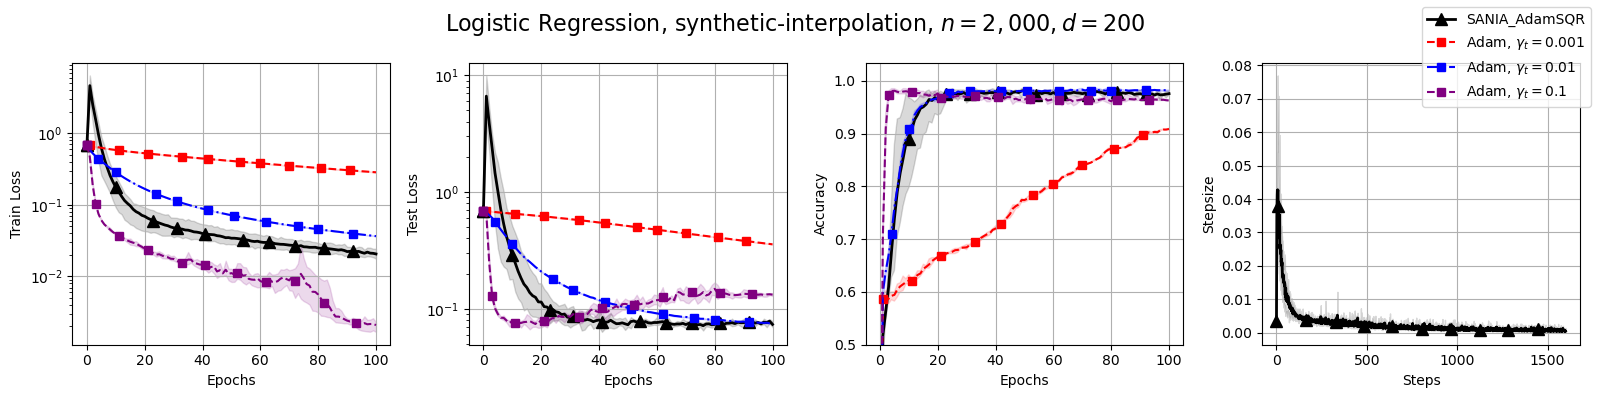

In [207]:
colors = ["black", "red", "blue", "purple", "teal", "lime"]
linestyles = ["-", "--", "-.", "--", "-", "--"]
linewidths = [2.0, 1.5, 1.5, 1.5, 1.5]

markers = ["^", "s", "s", "s", "s"]
markersizes = [8.0, 6.0, 6.0, 6.0, 6.0]

plotter(histories=all_histories, 
    labels=all_labels,
    colors=colors,
    linestyles=linestyles,
    linewidths=linewidths,
    markers=markers,
    markersizes=markersizes,
    ylim=0.5,
    suptitle=fr"Logistic Regression, {dataset_name}, $n={n:,}, d={d}$",
    filename=f"stepsizes_{dataset_name}_SANIA_AdamSQR.pdf",
    )

In [211]:
n_epochs = 100

batch_size = 100
lmd = 0.0

all_histories = []
all_labels = []

histories = []
optimizer = SANIA_AdagradSQR
eps = 1e-6
for seed in range(5):
    hist = train_loop(seed=seed, train_dataset=train_dataset, test_dataset=test_dataset, 
                    batch_size=batch_size, n_epochs=n_epochs, optimizer=optimizer,
                    lmd=lmd, eps=eps)
    histories.append(hist)
all_histories.append(histories)
all_labels.append(f"{optimizer.__name__}")

optimizer = Adagrad
for lr in [0.01, 0.1, 1.0]:
    histories = []
    for seed in range(5):
        hist = train_loop(seed=seed, train_dataset=train_dataset, test_dataset=test_dataset, 
                        batch_size=batch_size, n_epochs=n_epochs, optimizer=optimizer, 
                        lmd=lmd, lr=lr)
        histories.append(hist)
    all_histories.append(histories)
    all_labels.append(fr"{optimizer.__name__}, $\gamma_t={lr}$")


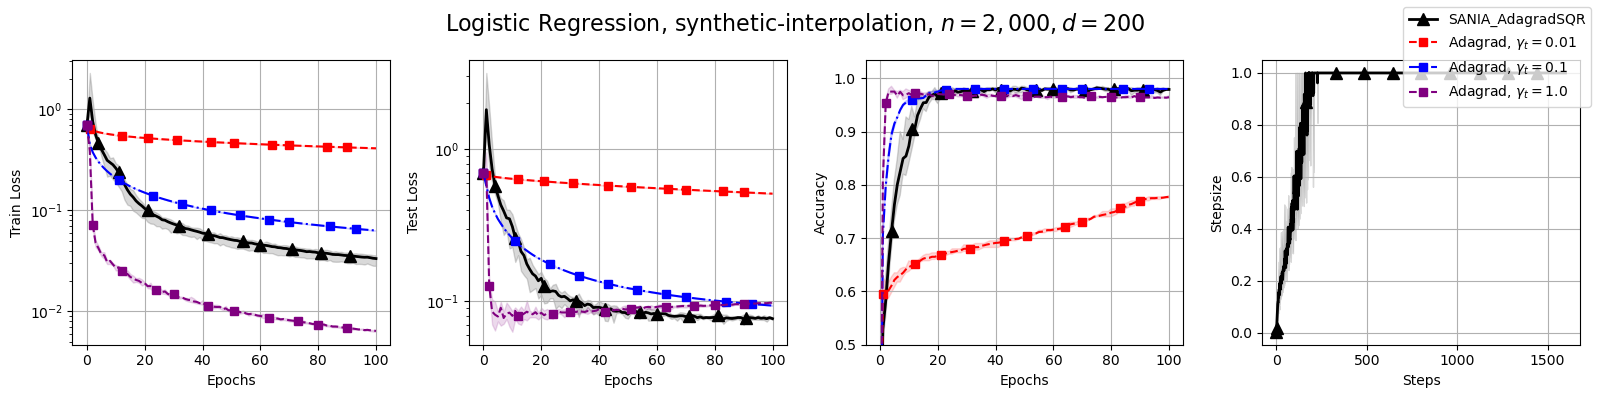

In [212]:
colors = ["black", "red", "blue", "purple", "teal", "lime"]
linestyles = ["-", "--", "-.", "--", "-", "--"]
linewidths = [2.0, 1.5, 1.5, 1.5, 1.5]

markers = ["^", "s", "s", "s", "s"]
markersizes = [8.0, 6.0, 6.0, 6.0, 6.0]

plotter(histories=all_histories, 
    labels=all_labels,
    colors=colors,
    linestyles=linestyles,
    linewidths=linewidths,
    markers=markers,
    markersizes=markersizes,
    ylim=0.5,
    suptitle=fr"Logistic Regression, {dataset_name}, $n={n:,}, d={d}$",
    filename=f"stepsizes_{dataset_name}_SANIA_AdagradSQR.pdf",
    )

In [219]:
n_epochs = 100

batch_size = 100
lmd = 0.0

all_histories = []
all_labels = []

histories = []
optimizer = SANIA_AdamSQR
eps = 1e-8
for seed in range(5):
    hist = train_loop(seed=seed, train_dataset=train_dataset, test_dataset=test_dataset, 
                    batch_size=batch_size, n_epochs=n_epochs, optimizer=optimizer,
                    lmd=lmd, eps=eps)
    histories.append(hist)
all_histories.append(histories)
all_labels.append(f"{optimizer.__name__}")

optimizer = Adam

lr_scheduler_dict = [
    {"name": "OneCycleLR", "eta_max": 0.1, "eta_min": 0.001, "t_up": 50, "t_total": 20 * n_epochs, "num_steps": 20 * n_epochs},
    {"name": "CosineAnnealingLR", "eta_max": 0.1, "eta_min": 0.01, "T_max": 500, "num_steps": 20 * n_epochs},
    {"name": "ExpDecayLR", "eta_init": 0.1, "eta_final": 0.0001, "T_max": 20 * n_epochs}
]

for lr_scheduler_kwargs in lr_scheduler_dict:
    histories = []
    for seed in range(5):
        hist = train_loop(seed=seed, train_dataset=train_dataset, test_dataset=test_dataset, 
                        batch_size=batch_size, n_epochs=n_epochs, optimizer=optimizer, lr_scheduler_kwargs=lr_scheduler_kwargs, 
                        lmd=lmd, lr=lr)
        histories.append(hist)
        
    all_histories.append(histories)
    all_labels.append(fr"{optimizer.__name__}, {lr_scheduler_kwargs["name"]}")


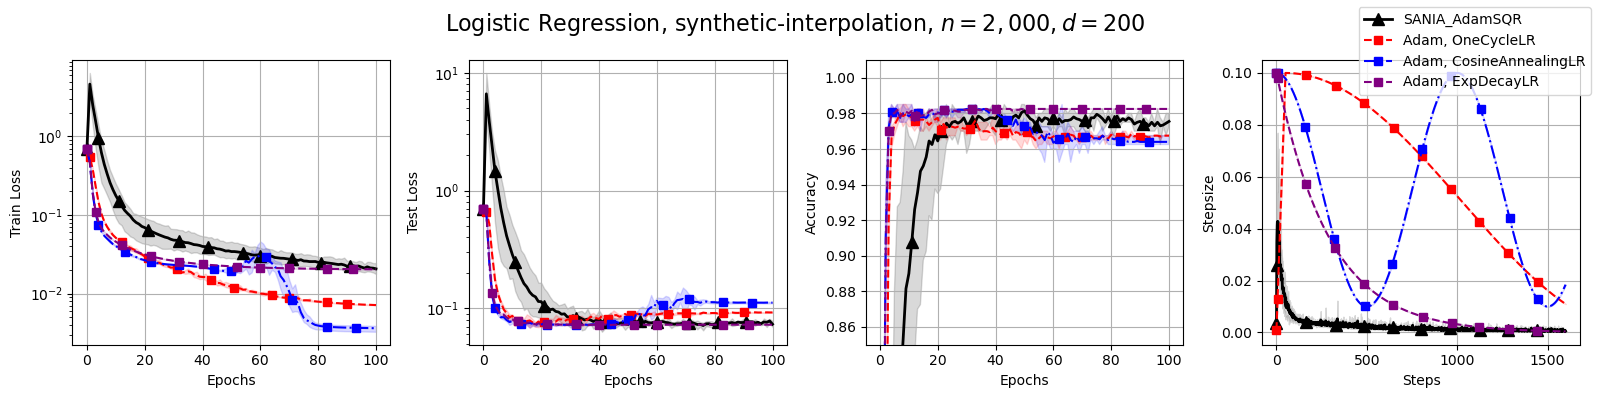

In [220]:
colors = ["black", "red", "blue", "purple", "teal", "lime"]
linestyles = ["-", "--", "-.", "--", "-", "--"]
linewidths = [2.0, 1.5, 1.5, 1.5, 1.5]

markers = ["^", "s", "s", "s", "s"]
markersizes = [8.0, 6.0, 6.0, 6.0, 6.0]

plotter(histories=all_histories, 
    labels=all_labels,
    colors=colors,
    linestyles=linestyles,
    linewidths=linewidths,
    markers=markers,
    markersizes=markersizes,
    ylim=0.85,
    suptitle=fr"Logistic Regression, {dataset_name}, $n={n:,}, d={d}$",
    filename=f"stepsizes_schedulers_{dataset_name}_SANIA_AdamSQR.pdf",
    )

In [221]:
n_epochs = 100

batch_size = 100
lmd = 0.0

all_histories = []
all_labels = []

histories = []
optimizer = SANIA_AdagradSQR
eps = 1e-6
for seed in range(5):
    hist = train_loop(seed=seed, train_dataset=train_dataset, test_dataset=test_dataset, 
                    batch_size=batch_size, n_epochs=n_epochs, optimizer=optimizer,
                    lmd=lmd, eps=eps)
    histories.append(hist)
all_histories.append(histories)
all_labels.append(f"{optimizer.__name__}")

optimizer = Adagrad

lr_scheduler_dict = [
    {"name": "OneCycleLR", "eta_max": 1.0, "eta_min": 0.01, "t_up": 50, "t_total": 20 * n_epochs, "num_steps": 20 * n_epochs},
    {"name": "CosineAnnealingLR", "eta_max": 1.0, "eta_min": 0.01, "T_max": 500, "num_steps": 20 * n_epochs},
    {"name": "ExpDecayLR", "eta_init": 1.0, "eta_final": 0.0001, "T_max": 20 * n_epochs}
]

for lr_scheduler_kwargs in lr_scheduler_dict:
    histories = []
    for seed in range(5):
        hist = train_loop(seed=seed, train_dataset=train_dataset, test_dataset=test_dataset, 
                        batch_size=batch_size, n_epochs=n_epochs, optimizer=optimizer, lr_scheduler_kwargs=lr_scheduler_kwargs, 
                        lmd=lmd, lr=lr)
        histories.append(hist)
        
    all_histories.append(histories)
    all_labels.append(fr"{optimizer.__name__}, {lr_scheduler_kwargs["name"]}")


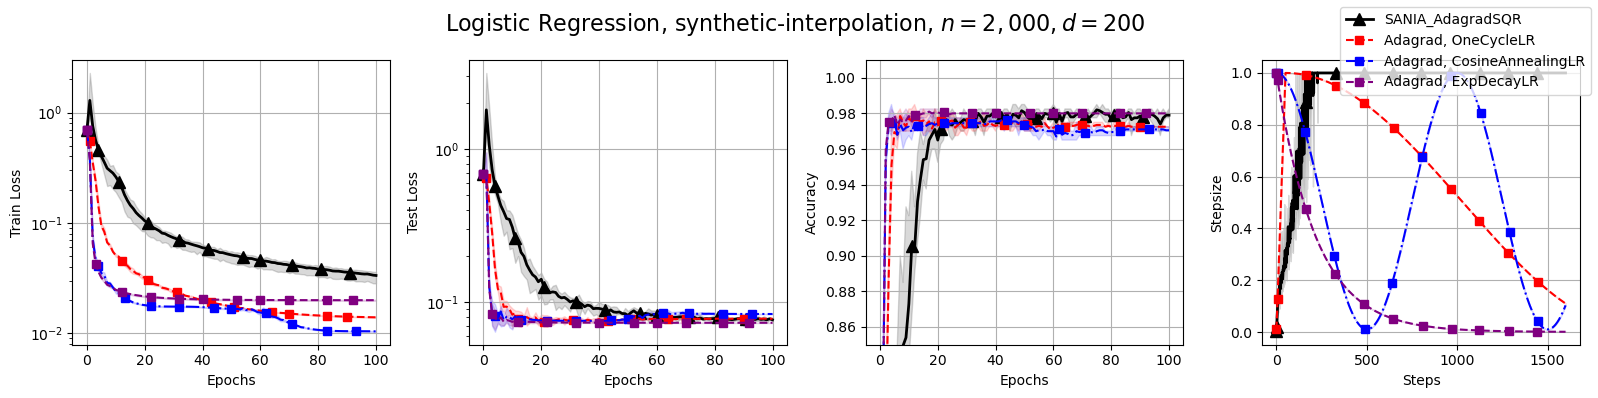

In [222]:
colors = ["black", "red", "blue", "purple", "teal", "lime"]
linestyles = ["-", "--", "-.", "--", "-", "--"]
linewidths = [2.0, 1.5, 1.5, 1.5, 1.5]

markers = ["^", "s", "s", "s", "s"]
markersizes = [8.0, 6.0, 6.0, 6.0, 6.0]

plotter(histories=all_histories, 
    labels=all_labels,
    colors=colors,
    linestyles=linestyles,
    linewidths=linewidths,
    markers=markers,
    markersizes=markersizes,
    ylim=0.85,
    suptitle=fr"Logistic Regression, {dataset_name}, $n={n:,}, d={d}$",
    filename=f"stepsizes_schedulers_{dataset_name}_SANIA_AdagradSQR.pdf",
    )